# **AI Agent_Memory 관리**

**Memory**
- AI Agent가 이전 상태(state)나 대화 기록을 유지하고 재사용할 수 있도록 하는 기능
    - 유저와 AI 간의 대화를 저장하여 지속적인 맥락을 유지
    - 단순한 세션 메모리 뿐만 아니라, 외부 저장소를 활용하여 장기적인 상태를 저장
- 단기기억과 장기기억 정보를 제어하기 위한 로직을 넣을 수 있음.
    

# 환경준비

In [76]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" "langchain-huggingface" "huggingface_hub" wikipedia -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-checkpoint-sqlite 3.0.1 requires langgraph-checkpoint<4.0.0,>=3, but you have langgraph-checkpoint 2.1.2 which is incompatible.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.3.81 which is incompatible.


In [77]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState, add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

## HuggingFace

In [78]:
import os
os.environ["HF_TOKEN"] = ""

## SerpAPI

In [79]:
import os
os.environ["SERPAPI_API_KEY"] = ""

# 기억력 없는 chatbot

## State 정의

In [82]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Node 정의

In [83]:
# llm = ChatOpenAI(model="gpt-4.1-mini")  # 언어 모델을 gpt-4.1-mini로 설정
# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

## 그래프 정의

In [84]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# compile the graph
graph = builder.compile()

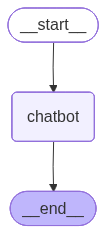

In [85]:
graph

## 그래프 실행

In [86]:
result = graph.invoke({"messages": [HumanMessage("안녕? 내 이름은 한기영이야.")]})
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

안녕? 내 이름은 한기영이야.
================================== Ai Message ==================================

안녕하세요, 한기영님! 만나서 반갑습니다. 오늘은 어떤 이야기를 나눠볼까요? 😊


In [87]:
result = graph.invoke({"messages": [HumanMessage("내 이름이 뭐라고?")]})
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

내 이름이 뭐라고?
================================== Ai Message ==================================

죄송하지만, 저는 사용자의 이름을 저장하거나 기억하고 있지 않아요. 혹시 알려주실 수 있나요?


## Agent에 메모리 추가

**메모리 종류**
- MemorySaver : Short-term Memory
- SqliteSaver : Long-term Memory


### (1) 메모리 준비 : MemorySaver
**MemorySaver**
- Short-term Memory
- LangGraph에서 제공하는 체크포인트(Checkpoint) 저장소
- 그래프 실행 중 생성되는 상태(state)를 자동으로 저장하고 필요 시 복원할 수 있게 해주는 메모리 기반 저장소
- 특징

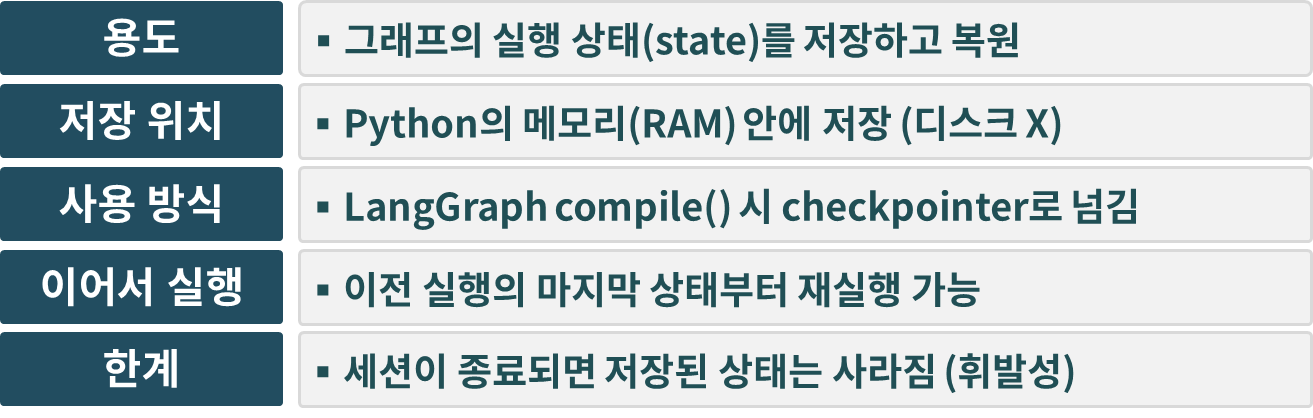   
  

In [88]:
# 체크포인터를 추가하여 그래프를 컴파일하면 메모리가 활성화됩니다.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver 모듈 가져오기
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화

### (2) 이전 그래프 다시 컴파일

In [89]:
# 체크포인터와 함께 그래프 컴파일
agent_with_memory = builder.compile(checkpointer=memory)

### (3) 실행

* 스레드 지정

In [90]:
# 대화 흐름을 구분하기 위한 thread_id 설정
# 각 실행 흐름(예: 특정 대화 스레드)에 대해 고유한 thread_id를 키로 사용하고, 해당 키에 상태 데이터를 저장합니다.
thread_1 = {"configurable": {"thread_id": "1"}}

In [91]:
messages = [HumanMessage(content="3과 4를 더하라")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하라
================================== Ai Message ==================================

7


In [92]:
messages = [HumanMessage(content="거기에 2를 곱하라.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하라
================================== Ai Message ==================================

7
================================ Human Message =================================

거기에 2를 곱하라.
================================== Ai Message ==================================

14


### (4) 새로운 대화

* 새로운 thread id 부여

In [93]:
# 새로운 스레드 id 부여
thread_2 = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="금리에 대한 정의를 알려줘.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_2)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

금리에 대한 정의를 알려줘.
================================== Ai Message ==================================

**금리(Interest Rate)란?**  
금리는 **채무(대출 등)를 빌린 자가 빚진 자에게 지급해야 할 보상**을 퍼센트(%)로 표시한 값입니다. 즉, “돈을 빌리는 비용”이자 동시에 “돈을 예치하거나 투자해 얻는 이익”을 의미합니다.

| 항목 | 내용 |
|------|------|
| **정의** | 1년(또는 특정 기간) 동안 채무자(또는 예금자)가 지불하거나 받는 금액을 원금에 대한 비율로 나타낸 것. |
| **표현 방식** | 보통 **연간 이자율(Annual Percentage Rate, APR)** 로 표시하지만, 월간, 일간 등 기간에 따라 “월이자율”, “일이자율” 등으로도 표기됩니다. |
| **구분** | 1. **명목금리(Nominal Rate)** – 인플레이션을 고려하지 않은 금리<br>2. **실질금리(Real Rate)** – 인플레이션(물가상승률)을 차감한 실제 구매력 변화를 나타내는 금리 |
| **주요 역할** | - 금융시장에서 자금의 **배분**과 **리스크 관리**에 결정적<br>- 대출·예금·채권·주식 등 다양한 금융 상품의 수익성·비용을 결정<br>- 중앙은행의 통화정책(금리 조정)을 통해 경제 전체의 인플레이션, 성장, 고용 등에 영향 미침 |

**간단히 말해**  
금리는 “돈을 빌리면 내야 하는 비용”이자 “돈을 맡기면 받을 수 있는 보상”을 퍼센트로 표현한 값이며, 금융 거래와 경제 정책에서 핵심적인 역할을 합니다.


* 이전 thread id로 다시 대화

In [94]:
# 첫 번째 입력 메시지를 정의
messages = [HumanMessage(content="마지막으로 계산했던 숫자가 뭐였지?")]

# 그래프 실행 (MemorySaver가 활성화된 그래프 사용)
messages = agent_with_memory.invoke({"messages": messages},thread_1)
# 결과 메시지를 출력
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

3과 4를 더하라
================================== Ai Message ==================================

7
================================ Human Message =================================

거기에 2를 곱하라.
================================== Ai Message ==================================

14
================================ Human Message =================================

마지막으로 계산했던 숫자가 뭐였지?
================================== Ai Message ==================================

마지막으로 계산한 숫자는 **14**입니다.


### (5) 실습
* 2번 파일의 실습1에 메모리를 추가해 봅시다.

* LLM을 하나 생성하시오 (ChatOpenAI)
* 다음 도구 3개를 load_tools()를 사용하여 불러오고, ToolNode로 묶으시오
    * llm-math, wikipedia, serpapi
* GPT에게 도구 목록을 알려주기 위해 .bind_tools(tools)를 사용하시오
* 이를 위해 필요한 준비작업을 수행하시오.
    * serpapi api key를 받아 등록
    * 필요한 라이브러리 설치

In [95]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode
from langchain.agents import load_tools
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool

* 1) 메모리 준비 : MemorySaver

In [96]:
# 체크포인터를 추가하여 그래프를 컴파일하면 메모리가 활성화됩니다.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver 모듈 가져오기
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화

* 2) Tool 준비하기

In [97]:
!pip install google-search-results -q

In [98]:
from langchain.agents import load_tools

# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)
tools = load_tools(["llm-math", "wikipedia", "serpapi"], llm=llm) # 일부 툴이 LLM을 내부적으로 쓸 때 필요한 설정

* 3) ToolNode 생성

In [99]:
tool_node = ToolNode(tools)

# 툴을 쓸 수 있는 LLM
llm_with_tools = llm.bind_tools(tools)  # GPT가 이 툴들을 사용하겠다고 판단할 수 있게 도와주는 설정

* 4) 그래프 만들기

* State

In [100]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [101]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

In [102]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

# connect nodes
builder.add_edge(START, "agent") # 시작 -> 에이전트 호출
builder.add_conditional_edges(
    "agent",
    should_continue, # 도구가 필요한지 판단하는 함수
)
builder.add_edge("tools", "agent") # 도구 실행 후 다시 에이전트에게 결과 전달

# compile the graph
graph = builder.compile()

* 그래프 시각화

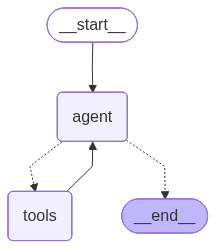

In [103]:
graph

* 5) 그래프 사용하기

In [104]:
# 대화 흐름을 구분하기 위한 thread_id 설정
# 각 실행 흐름(예: 특정 대화 스레드)에 대해 고유한 thread_id를 키로 사용하고, 해당 키에 상태 데이터를 저장합니다.
th_1 = {"configurable": {"thread_id": "1"}}

In [105]:
result = graph.invoke({"messages": [HumanMessage("서울 현재 기온을 알려주고 그 값의 제곱근을 구해줘.")]})
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

서울 현재 기온을 알려주고 그 값의 제곱근을 구해줘.
================================== Ai Message ==================================
Tool Calls:
  Search (fc_dc8c3dfe-a871-46a4-a976-ef738dd624a8)
 Call ID: fc_dc8c3dfe-a871-46a4-a976-ef738dd624a8
  Args:
    __arg1: 현재 기온 서울
================================= Tool Message =================================
Name: Search

{'type': 'weather_result', 'temperature': '14', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '49%', 'wind': '4 mph', 'location': '대한민국 서울특별시', 'date': 'Saturday 12:00 AM', 'weather': 'Clear'}
================================== Ai Message ==================================

현재 서울의 기온은 **14 °F (약 –10 °C)** 입니다.  
해당 온도(14 °F)의 제곱근은 다음과 같습니다:

\[
\sqrt{14} \approx 3.7417
\]

따라서 제곱근 값은 **약 3.74** 입니다.


# 메모리 다루기

## (1) 메모리 조회

* thread id 1 에 저장된 메모리 스냅샷

In [106]:
agent_with_memory.get_state(thread_1).values

{'messages': [HumanMessage(content='3과 4를 더하라', additional_kwargs={}, response_metadata={}, id='aa819864-e74b-4c01-acdd-88df9b6e6a41'),
  AIMessage(content='7', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 79, 'total_tokens': 150}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e2cb7a84ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--29053d91-8a17-4ace-b421-27c0e91886b9-0', usage_metadata={'input_tokens': 79, 'output_tokens': 71, 'total_tokens': 150}),
  HumanMessage(content='거기에 2를 곱하라.', additional_kwargs={}, response_metadata={}, id='4bb32f34-2230-4b9e-860b-9872087174b3'),
  AIMessage(content='14', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 100, 'total_tokens': 180}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_334cc21c60', 'finish_reason': 'stop', 'logprobs': None}, id='run--9d8445c1-223a-42db-9e09-4782f2074ed6-0', usage_metadata={'i

In [107]:
temp = agent_with_memory.get_state(thread_1).values
temp['messages'][-1].content

'마지막으로 계산한 숫자는 **14**입니다.'

* thread id 2 에 저장된 메모리 스냅샷

In [108]:
agent_with_memory.get_state(thread_2).values

{'messages': [HumanMessage(content='금리에 대한 정의를 알려줘.', additional_kwargs={}, response_metadata={}, id='76c57640-5193-44f5-af6e-66f190967bab'),
  AIMessage(content='**금리(Interest Rate)란?**  \n금리는 **채무(대출 등)를 빌린 자가 빚진 자에게 지급해야 할 보상**을 퍼센트(%)로 표시한 값입니다. 즉, “돈을 빌리는 비용”이자 동시에 “돈을 예치하거나 투자해 얻는 이익”을 의미합니다.\n\n| 항목 | 내용 |\n|------|------|\n| **정의** | 1년(또는 특정 기간) 동안 채무자(또는 예금자)가 지불하거나 받는 금액을 원금에 대한 비율로 나타낸 것. |\n| **표현 방식** | 보통 **연간 이자율(Annual Percentage Rate, APR)** 로 표시하지만, 월간, 일간 등 기간에 따라 “월이자율”, “일이자율” 등으로도 표기됩니다. |\n| **구분** | 1. **명목금리(Nominal Rate)** – 인플레이션을 고려하지 않은 금리<br>2. **실질금리(Real Rate)** – 인플레이션(물가상승률)을 차감한 실제 구매력 변화를 나타내는 금리 |\n| **주요 역할** | - 금융시장에서 자금의 **배분**과 **리스크 관리**에 결정적<br>- 대출·예금·채권·주식 등 다양한 금융 상품의 수익성·비용을 결정<br>- 중앙은행의 통화정책(금리 조정)을 통해 경제 전체의 인플레이션, 성장, 고용 등에 영향 미침 |\n\n**간단히 말해**  \n금리는 “돈을 빌리면 내야 하는 비용”이자 “돈을 맡기면 받을 수 있는 보상”을 퍼센트로 표현한 값이며, 금융 거래와 경제 정책에서 핵심적인 역할을 합니다.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 556, 'prompt_tokens'

*  메모리 삭제
    * 공식적으로 제공되지 않음.
    * Thread id를 새로 시작하거나,
    * memory 인스턴스를 다시 지정

## (2) 최근 메시지 n개만 기억

기억할 메세지 개수 제한하기

* node 정의

In [109]:
def filter_messages(messages: list):
    # 최근 2개 메시지만 리턴하는 필터 함수 생성
    return messages[-2:]

def chatbot(state: State):
    messages = filter_messages(state["messages"])
    result = llm.invoke(messages)
    return {"messages": [result]}

* 그래프 정의

In [110]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 체크포인터와 함께 그래프 컴파일
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화
agent_with_memory = builder.compile(checkpointer=memory)

In [111]:
config_10 = {"configurable": {"thread_id": "10"}}
messages = [HumanMessage(content="3과 4를 더하라")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="내 이름은 한기영이야.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="오늘 날씨 어때?")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="아까 계산했던 값이 얼마?")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

================================== Ai Message ==================================

7
================================== Ai Message ==================================

안녕하세요, 한기영님! 만나서 반갑습니다. 오늘 무엇을 도와드릴까요?
================================== Ai Message ==================================

현재 실시간 기상 정보를 바로 확인할 수는 없어요.  
원하시는 지역을 알려주시면, 그 지역의 일반적인 기후와 예보를 안내해 드릴게요!  
또는 스마트폰이나 웹사이트(예: 네이버 날씨, 기상청)에서 바로 현재 온도와 예보를 확인하실 수 있습니다.
================================== Ai Message ==================================

아까 계산했던 값은  
\[
P(\text{7개가 모두 서로 다름})=\frac{8}{8}\times\frac{7}{8}\times\frac{6}{8}\times\frac{5}{8}\times\frac{4}{8}\times\frac{3}{8}\times\frac{2}{8}
= \frac{7!}{8^{6}}
\]

\[
\frac{7!}{8^{6}}=\frac{5040}{262\,144}= \frac{315}{16\,384}\approx 0.01923
\]

즉, 대략 **1.92 %** (정확히는 \(315/16384\)) 확률이 됩니다.


## (3) [추가] 메시지 요약

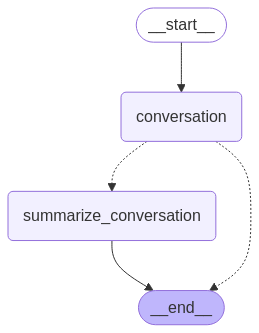

In [112]:
memory = MemorySaver()

### 1) State
* MessagesState는 LangGraph가 기본 제공하는 메시지 기반 상태
* 여기에 **summary**라는 새로운 필드를 추가
* state 구조


    {
        "messages": [...],  # 전체 대화 기록
        "summary": "지금까지 요약된 내용"
    }

In [113]:
class State(MessagesState):
    summary: str

### 2) 노드와 분기함수

* **대화 노드**

    * 기존 메시지 리스트로 GPT를 호출해서 응답을 받고,
    * 그 응답을 메시지 리스트에 **누적시킬 준비**를 해줌

In [114]:
def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        # 요약을 system prompt로 넣어 대화 맥락 유지
        system_message = f"이전 대화 요약: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

* **분기 조건**
    * 메시지가 6개 초과하면 **summarize_conversation** 노드로 분기
    * 그렇지 않으면 바로 **END**

In [115]:
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    if len(state["messages"]) > 6:
        return "summarize_conversation"
    return END

* **요약 노드**
    * 지금까지 대화 내용으로 요약 생성
    * 메시지 너무 많아지지 않도록 앞쪽 메시지 삭제
    * 요약은 state["summary"]에 저장됨 (누적 요약 느낌)

In [116]:
from langchain_core.messages import RemoveMessage

def summarize_conversation(state: State):
    summary = state.get("summary", "")   # 이전에 요약된게 있다면, 불러오고, 없으면 ""
    if summary:
        # 이전에 요약이 있다면:
        # 요약 내용을 GPT에게 보여주고
        # “여기에 새 메시지를 반영해서 요약을 이어서 해줘” 요청
        summary_message = (
            f"지금까지 요약된 내용 : {summary}\n\n"
            "여기에 새 메시지를 반영해서 요약을 이어서 해주세요. :" )
    else:
        # 이전 요약이 없다면 (처음 요약) → 대화 전체를 요약해달라고 지시
        summary_message = "대화 내용을 요약해주세요.:"

    # 기존 메시지 목록 끝에 요약 요청 프롬프트를 HumanMessage로 추가
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 전체 메시지 + 요약 요청을 GPT에게 전달해서 요약 결과 받기
    response = llm.invoke(messages)

    # 오래된 메시지를 제거 → 최신 2개만 유지
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

### 3) 그래프 정의

In [117]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [118]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

1. 처음 6개 대화 → END
2. 7번째 입력 → summarize_conversation 실행
    * 요약1 생성
    * 오래된 메시지 삭제
3. 또 6개 쌓이면 → 요약2 생성
    * 기존 요약 + 새 메시지로 “요약 이어 쓰기”
    * 다시 삭제

### 4) 대화 시작

* 출력 함수 생성

| 부분 | 설명 |
| ---- | ---- |
| update | 그래프 노드 실행 후 변경된 상태 정보 |
| messages | LLM 대화 메시지 리스트 |
| summary | 누적된 요약 정보 (있으면 출력) |
| pretty_print() | 메시지를 보기 좋게 출력하는 LangChain 메서드 |

In [119]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

In [120]:
config = {"configurable": {"thread_id": "10"}}
input_message = HumanMessage(content="안녕? 내 이름은 핑크퐁이야")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="내이름이 뭐라고?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="나는 FC 바르셀로나를 좋아해!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕? 내 이름은 핑크퐁이야
================================== Ai Message ==================================

안녕하세요, 핑크퐁! 반가워요. 오늘은 어떻게 지내시나요? 궁금한 건 있으신가요?
================================ Human Message =================================

내이름이 뭐라고?
================================== Ai Message ==================================

당신의 이름은 **핑크퐁**이에요. 😊
================================ Human Message =================================

나는 FC 바르셀로나를 좋아해!
================================== Ai Message ==================================

아, FC 바르셀로나라면 멋지네요! 스페인 라리가에서의 경기 중 가장 좋아하는 선수는 누구인가요? 혹은 언제가 가장 기억에 남는 경기인가요? 알려주시면 같이 이야기 나눠볼게요!


In [121]:
# 지금까지 요약이 이루어지지 않음
# 목록에 메시지가 6개뿐이기 때문입니다.

values = app.get_state(config).values
values

{'messages': [HumanMessage(content='안녕? 내 이름은 핑크퐁이야', additional_kwargs={}, response_metadata={}, id='3b57e0da-1586-4fdc-a0e3-fbc1f9c3e858'),
  AIMessage(content='안녕하세요, 핑크퐁! 반가워요. 오늘은 어떻게 지내시나요? 궁금한 건 있으신가요?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 85, 'total_tokens': 191}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_2b688e7cc3', 'finish_reason': 'stop', 'logprobs': None}, id='run--d54f2ad6-9bbb-45cd-a251-58a044547ba2-0', usage_metadata={'input_tokens': 85, 'output_tokens': 106, 'total_tokens': 191}),
  HumanMessage(content='내이름이 뭐라고?', additional_kwargs={}, response_metadata={}, id='af5a8f9b-ef2a-43d1-a1de-40acdcf9e525'),
  AIMessage(content='당신의 이름은 **핑크퐁**이에요. 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 134, 'total_tokens': 212}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_99996fee8e', 'finish_reason': 'stop', 'logprobs': None},

* 이제 한번 더 이야기하면, 과거 6개 메시지가 요약되고, 삭제 됩니다.

In [122]:
input_message = HumanMessage(content="나는 그들이 항상 이기는게 좋아.")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

나는 그들이 항상 이기는게 좋아.
================================== Ai Message ==================================

바르셀로나가 항상 승리하는 모습을 보는 건 정말 멋진 기분이죠! 특히 라리가와 챔피언스리그에서 그들이 보여주는 화려한 플레이와 전술은 언제나 눈을 사로잡습니다. 

혹시 최근에 그들이 이긴 경기 중에서 특히 인상 깊었던 순간이나 플레이어가 있나요? 아니면 바르셀로나를 사랑하게 된 특별한 계기가 있었나요? 함께 얘기 나눠보면 더 재미있을 것 같아요!
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


**대화 요약**

1. 사용자는 자신을 “핑크퐁”이라고 소개하고, 반가움 인사를 했다.  
2. 사용자는 자신의 이름이 무엇인지 물었고, “핑크퐁”이라고 답했다.  
3. 사용자는 FC 바르셀로나를 좋아한다고 말했다. 

In [123]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='나는 그들이 항상 이기는게 좋아.', additional_kwargs={}, response_metadata={}, id='4c2ce4a2-44b6-453c-885c-a03e6b362577'),
  AIMessage(content='바르셀로나가 항상 승리하는 모습을 보는 건 정말 멋진 기분이죠! 특히 라리가와 챔피언스리그에서 그들이 보여주는 화려한 플레이와 전술은 언제나 눈을 사로잡습니다. \n\n혹시 최근에 그들이 이긴 경기 중에서 특히 인상 깊었던 순간이나 플레이어가 있나요? 아니면 바르셀로나를 사랑하게 된 특별한 계기가 있었나요? 함께 얘기 나눠보면 더 재미있을 것 같아요!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 246, 'total_tokens': 417}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_228717f27c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b185d3d4-8de5-408c-8afe-51b9d2d61342-0', usage_metadata={'input_tokens': 246, 'output_tokens': 171, 'total_tokens': 417})],
 'summary': '**대화 요약**\n\n1. 사용자는 자신을 “핑크퐁”이라고 소개하고, 반가움 인사를 했다.  \n2. 사용자는 자신의 이름이 무엇인지 물었고, “핑크퐁”이라고 답했다.  \n3. 사용자는 FC 바르셀로나를 좋아한다고 말했다.  \n4. 사용자는 팀이 항상 이기는 것을 선호한다고 덧붙였다.  \n5. 지금은 전체 대화 내용을 요약해 달라고 요청했다.'}

이제 대화를 계속할 수 있습니다! 마지막 두 개의 메시지만 있지만 대화에서 앞서 언급한 내용에 대해 여전히 질문할 수 있습니다(요약했기 때문입니다)

In [124]:
input_message = HumanMessage(content="참, 내 이름이 뭐라고?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

참, 내 이름이 뭐라고?
================================== Ai Message ==================================

당신의 이름은 **핑크퐁**입니다! 🚀


In [125]:
input_message = HumanMessage(content="내가 좋아하는 축구팀은?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

내가 좋아하는 축구팀은?
================================== Ai Message ==================================

당신이 좋아하는 축구팀은 **FC 바르셀로나**입니다! 🚀


In [126]:
input_message = HumanMessage(content="우리팀과 경쟁하는 팀이 어디야?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

우리팀과 경쟁하는 팀이 어디야?
================================== Ai Message ==================================

### 바르셀로나와 가장 자주 경쟁하는 팀들

| 종류 | 팀 | 주요 경기 / 이유 |
|------|----|-------------------|
| **스페인 리그 (라리가) 상대** | **레알 마드리드** | *엘 클라시코* – 스페인 내에서 가장 열띤 라이벌 관계. 경기마다 팬들의 열기와 미디어 집중도가 최고입니다. |
| | **레알 세비야** | 2017‑18 시즌 이후 라리가 1위와 2위 경쟁으로 주목받는 팀. |
| | **레알 발렌시아** | 과거 바르셀로나의 전통적 라이벌 중 하나. |
| | **아틀레티코 마드리드** | 리그 2위권을 자주 차지하며 바르셀로나의 시즌 타이틀 경쟁자. |
| | **레알 소시에다** | 2010‑21 시즌부터 꾸준히 1, 2위 사이를 움직이며 경쟁이 치열합니다. |
| | **바르셀로나** | 2018‑19 시즌 이후 상위 4강에 진입한 팀으로, 시즌 내내 꾸준히 위기감을 줍니다. |
| | **에스파냐 (Athletic Bilbao)** | 전통적인 스페인 팀 중 하나로, 바르셀로나와 역사적으로 경쟁 관계에 있습니다. |

| 종류 | 팀 | 주요 경기 / 이유 |
|------|----|-------------------|
| **유럽 챔피언스리그 (UEFA Champions League) 상대** | **바이에른 뮌헨** | 2013‑14, 2020‑21 시즌 챔피언스리그 결승전에서 바르셀로나가 대결한 팀. |
| | **파리 생제르맹** | 2020‑21 시즌, 바르셀로나가 대회에서 진출을 거부한 팀. |
| | **리버풀** | 2017‑18 시즌 챔피언스리그 4강에서 대결한 

# 실습

## (1) 실습1
* 최근 메시지 n개만 기억 : 기억할 메세지 개수 제한하기
    * 기존 코드 수정하기
    * 포함사항 : 시스템 메시지(역할) 지정하기(chatbot 함수에 추가)
    * agent를 만들고 대화하면서 이전 메시지가 제외되는지 확인하기

* node 정의

In [127]:
def filter_messages(messages: list, k: int = 3):
    # 시스템 메시지는 최상단에 고정
    system_msg = SystemMessage(content="당신은 요약과 계산을 잘하는 유능한 비서입니다.")

    # 최근 메시지 k개만 추출 (Human/AI/Tool 메시지 포함)
    recent_messages = messages[-k:]

    # 시스템 메시지를 맨 앞에 붙여서 반환
    return [system_msg] + recent_messages

In [150]:
def chatbot(state: State):
    # 필터링 적용: 최근 3개의 메시지만 LLM에 전달
    filtered_history = filter_messages(state["messages"], k=3)

    # 도구가 바인딩된 LLM 호출
    response = llm_with_tools.invoke(filtered_history)

    # 추가 메타데이터(JSON 변환을 방해하는 요소)를 비워서 보냄
    response.additional_kwargs = {}

    return {"messages": [response]}

In [130]:
# 이 코드를 다시 한 번 실행해서 메모리를 갱신하세요!
def should_continue(state: State) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]

    # 1. 툴 호출이 필요한 경우
    if last_message.tool_calls:
        return "tools"

    # 2. 대화를 종료하는 경우 (summarize_conversation 대신 END 사용)
    return END

* 그래프 정의

In [151]:
# 기존의 call_model 대신 chatbot 함수를 사용합니다.
builder = StateGraph(State)

# 노드 등록
builder.add_node("agent", chatbot)  # 여기서 chatbot 함수 사용
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue)
builder.add_edge("tools", "agent")

graph = builder.compile(checkpointer=memory)

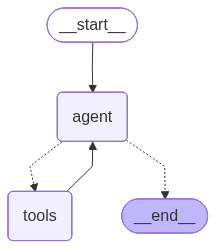

In [152]:
graph

In [134]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="안녕? 내 이름은 핑크퐁이야")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="오늘 날씨 어때?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="1+1은 뭐야?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="내 이름이 뭐라고 했지?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕? 내 이름은 핑크퐁이야
================================== Ai Message ==================================

안녕하세요, 핑크퐁님! 😊 오늘은 어떤 이야기를 나눠볼까요? 궁금한 게 있거나 도와드릴 일이 있으면 언제든 말씀해 주세요!
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


**대화 요약**

1. 사용자는 인사와 함께 “내 이름은 핑크퐁이야”라고 말했습니다.  
2. Assistant는 인사를 하고 사용자의 이름을 확인했습니다.  
3. 사용자는 “내이름이 뭐라고?” 라고 다시 물었고, Assistant는 이름을 “핑크퐁”이라고 알려줬습니다.  
4. 사용자는 FC 바르셀로나를 좋아한다고 말했고, Assistant는 그와 관련해 좋아하는 선수, 기억에 남는 경기, 기대되는 경기 등에 대해 물어보며 대화를 이어갔습니다.

## (2) [추가] 실습2
메시지 요약

위 실습1의 메모리를 요약 메모리로 변경해 봅시다.

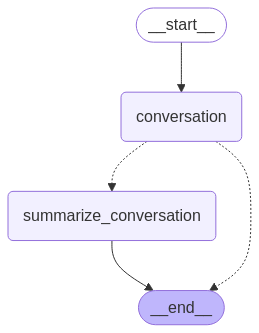

* 1) State
    * MessagesState는 LangGraph가 기본 제공하는 메시지 기반 상태
    * 여기에 **summary**라는 새로운 필드를 추가

In [135]:
class State(MessagesState):
    summary: str

* 2) 노드와 분기함수

* **대화 노드**

    * 기존 메시지 리스트로 GPT를 호출해서 응답을 받고,
    * 그 응답을 메시지 리스트에 **누적시킬 준비**를 해줌

In [136]:
def call_model(state: State):
    summary = state.get("summary", "")

    # 요약 정보가 있다면 시스템 메시지에 추가하여 문맥 유지
    if summary:
        system_str = f"이전 대화 요약: {summary}\n당신은 유능한 비서입니다."
        messages = [SystemMessage(content=system_str)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

* **분기 조건**
    * 메시지가 6개 초과하면 **summarize_conversation** 노드로 분기
    * 그렇지 않으면 바로 **END**

In [138]:
def should_summarize(state: State) -> Literal["summarize_conversation", END]:
    messages = state["messages"]

    # 메시지가 6개를 초과하면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"

    return END

* **요약 노드**
    * 지금까지 대화 내용으로 요약 생성
    * 메시지 너무 많아지지 않도록 앞쪽 메시지 삭제
    * 요약은 state["summary"]에 저장됨 (누적 요약 느낌)

In [139]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        # 기존 요약이 있는 경우 새로운 메시지와 합쳐서 업데이트
        summary_message = f"기존 요약: {summary}\n\n새로운 대화 내역을 포함하여 전체 내용을 다시 요약하세요."
    else:
        summary_message = "지금까지의 대화 내용을 요약하세요."

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # 앞쪽 메시지를 삭제하기 위한 RemoveMessage 생성 (마지막 2개만 남기고 삭제 예시)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

* 3) 그래프 정의

In [140]:
# 빌더 초기화
builder = StateGraph(State)

# 노드 등록
builder.add_node("agent", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# 엣지 연결
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    should_summarize,
)
builder.add_edge("summarize_conversation", END)

# 컴파일
graph = builder.compile(checkpointer=memory)

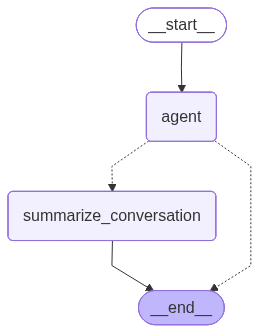

In [141]:
graph

* 4) 대화 시작

* 출력 함수 생성

| 부분 | 설명 |
| ---- | ---- |
| update | 그래프 노드 실행 후 변경된 상태 정보 |
| messages | LLM 대화 메시지 리스트 |
| summary | 누적된 요약 정보 (있으면 출력) |
| pretty_print() | 메시지를 보기 좋게 출력하는 LangChain 메서드 |


In [143]:
# 1. 초기 설정 (대화를 구분할 thread_id 생성)
config = {"configurable": {"thread_id": "5"}}

input_message = HumanMessage(content="안녕? 나는 서울에 살고 있는 철수라고 해.")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)


input_message = HumanMessage(content="내가 제일 좋아하는 음식은 김치찌개야.")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="오늘 점심에는 뭘 먹으면 좋을까?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕? 나는 서울에 살고 있는 철수라고 해.
================================== Ai Message ==================================

안녕하세요, 철수님! 서울에서 생활 중이시라니 멋지네요. 오늘 궁금한 점이나 도움이 필요하신 게 있나요? 언제든 말씀해 주세요!
================================ Human Message =================================

내가 제일 좋아하는 음식은 김치찌개야.
================================== Ai Message ==================================

김치찌개라니, 진짜 맛있죠! 특히 매콤하고 얼큰한 국물에 고기와 두부, 야채가 잘 어우러지면 한 그릇이면 기분이 훨씬 좋아지더라고요. 서울에서 자주 가는 김치찌개 맛집이 있나요? 아니면 집에서 직접 만들어 보시나요? 궁금한 점이 있으면 언제든 도와드릴게요!
================================ Human Message =================================

오늘 점심에는 뭘 먹으면 좋을까?
================================== Ai Message ==================================

좋은 점심을 선택하려면 몇 가지 포인트를 한 번 짚어보면 더 즐거워요!  
- **시간**: 아침 식사 후 바로 먹을 수 있는 가볍거나, 점심시간이 길면 좀 더 푸짐한 메뉴  
- **식단**: 고기, 해산물, 채식, 혹은 매운 음식을 원하시는지  
- **예산**: 편의점, 길거리 음식, 맛집 등  
- **위치**: 지금 어디에 계시나요? (역 근처인지, 도심인지)  

아래에 몇 가지 아이디어를 

* 이제 한번 더 이야기하면, 과거 6개 메시지가 요약되고, 삭제 됩니다.

In [144]:
input_message = HumanMessage(content="지금까지 우리 무슨 얘기 했는지 기억나?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

지금까지 우리 무슨 얘기 했는지 기억나?
================================== Ai Message ==================================

네! 지금까지 우리 대화 내용을 간단히 정리해 드릴게요.  

| 순서 | 내용 | 핵심 포인트 |
|------|------|-------------|
| 1 | 인사 & 자기 소개 | “안녕? 나는 서울에 살고 있는 철수라고 해.” |
| 2 | 좋아하는 음식 | “김치찌개가 제일 좋아하는 음식” |
| 3 | 점심 메뉴 제안 요청 | “오늘 점심에는 뭘 먹으면 좋을까?” |
| 4 | 답변 | 1️⃣ 김치찌개와 비슷한 한식 메뉴 (김치찌개, 두부김치, 순두부찌개 등)  <br> 2️⃣ 가볍게 먹는 옵션 (김밥, 라면) <br> 3️⃣ 정찬 옵션 (김치찌개+두부김치+고기) <br> 4️⃣ 해물파전, 비빔밥 등 대안 제시 <br> 5️⃣ 집에서 만들기 팁과 편의점 즉석 제품 소개 |

간단히 정리하면:  
- **철수**님이 서울에 살고 있고, 김치찌개를 가장 좋아함.  
- 점심 메뉴를 찾고 있는데, 김치찌개 기반 한식, 가벼운 한식, 해물, 채식 등 다양한 옵션을 제안했습니다.  
- 또한 집에서 김치찌개를 만드는 방법과 편의점에서 즉석으로 구매할 수 있는 방법도 공유했습니다.  

혹시 더 궁금한 점이 있거나, 다른 음식 종류에 대해 더 알고 싶으시면 언제든 말씀해 주세요!
================================ Remove Message ================================


================================ Remove Message ================================


================================ 

이제 대화를 계속할 수 있습니다! 마지막 두 개의 메시지만 있지만 대화에서 앞서 언급한 내용에 대해 여전히 질문할 수 있습니다(요약했기 때문입니다)

# 체크포인트 저장소(Checkpoint Store)

SQLite DB

**구성**
- checkpoints.sqlite
    - 메인 데이터베이스 파일
    - 모든 데이터의 기본 저장소
- checkpoints.sqlite-wal
    - 쓰기 로그(Write-Ahead Log)
    - 최신 변경사항이 일시적으로 저장됨
- checkpoints.sqlite-shm
    - 공유 메모리 파일 (Shared Memory)



In [145]:
!pip install langgraph-checkpoint-sqlite -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph 0.2.76 requires langgraph-checkpoint<3.0.0,>=2.0.10, but you have langgraph-checkpoint 3.0.1 which is incompatible.
langgraph-prebuilt 1.0.5 requires langchain-core>=1.0.0, but you have langchain-core 0.3.81 which is incompatible.


In [146]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

## (1) DB 생성 및 연결

In [147]:
# check_same_thread=False - 여러 스레드에서 같은 연결 객체를 공유할 수 있도록 허용
# LangGraph나 LangChain은 비동기 처리 또는 멀티 스레드 실행을 사용하는 경우가 많아.

sqlite3_conn = sqlite3.connect('checkpoints.sqlite',check_same_thread=False)
sqlite3_memory_checkpoint = SqliteSaver(sqlite3_conn)

## (2) 메모리 지정

In [148]:
graph = builder.compile(checkpointer=sqlite3_memory_checkpoint)

## (3) 대화

In [153]:
graph.invoke(
    {"messages": [HumanMessage("안녕?")]},
    config={"configurable": {"thread_id": 1}}
)

HfHubHTTPError: Client error '402 Payment Required' for url 'https://router.huggingface.co/v1/chat/completions' (Request ID: Root=1-6957e5a0-305a00375dfba86d670e5f44;ac677cbc-de83-48f0-b433-9954940dce8b)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/402

You have reached the free monthly usage limit for groq. Subscribe to PRO to get 20x more included usage, or add pre-paid credits to your account.

In [ ]:
graph.invoke(
    {"messages": [HumanMessage("내이름은 한기영")]},
    config={"configurable": {"thread_id": 1}}
)